In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
from jcopml.tuning.space import Integer, Real

import matplotlib.pyplot as plt
import seaborn as sns

# Import Datasets

In [3]:
df = pd.read_csv("datasets/weatherAUS.csv", parse_dates=["Date"])

# buat kolom year yang berisi data tahun hasil ekstraksi kolom date
df['year'] = pd.DatetimeIndex(df['Date']).year

# buat kolom month yang berisi hasil ekstraksi bulan pada kolom date
df['month'] = pd.DatetimeIndex(df['Date']).month

# buat kolom day yang berisi hari
df['day'] = pd.DatetimeIndex(df['Date']).day

# hapus kolom Date karena sudah tidak terpakai
df = df.drop(columns="Date")

# tampilkan dataframe
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,year,month,day
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,8.0,NaN,16.9,21.8,No,0.0,No,2008,12,1
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,NaN,NaN,17.2,24.3,No,0.0,No,2008,12,2
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,NaN,2.0,21.0,23.2,No,0.0,No,2008,12,3
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,NaN,NaN,18.1,26.5,No,1.0,No,2008,12,4
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,7.0,8.0,17.8,29.7,No,0.2,No,2008,12,5


# Datasets Splitting

In [4]:
X = df.drop(columns="RainTomorrow")
y = df["RainTomorrow"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((113754, 25), (28439, 25), (113754,), (28439,))

# Simple Logistic Regression
### Preprocessor

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

from sklearn.metrics import f1_score, recall_score, precision_score

In [11]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard',transform='yeo-johnson'), X_train.describe().columns),
    ('categoric', cat_pipe(encoder='onehot'), X_train.select_dtypes('object').columns)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

### Training

In [18]:
parameter_tune = {
    'algo__fit_intercept': [True],
    'algo__C': Real(low=-3, high=-1, prior='log-uniform')
}

In [19]:
model = RandomizedSearchCV(pipeline, parameter_tune, cv=4, n_iter=12, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))
print(f1_score(y_test, model.predict(X_test), pos_label="Yes"))

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.8min finished


{'algo__C': 0.07969454818643937, 'algo__fit_intercept': True}
0.9999912091003393 0.9999912089457768 0.9999648370195858
0.9999215747784488


### Scoring Model

In [21]:
from jcopml.plot import plot_correlation_matrix, plot_confusion_matrix

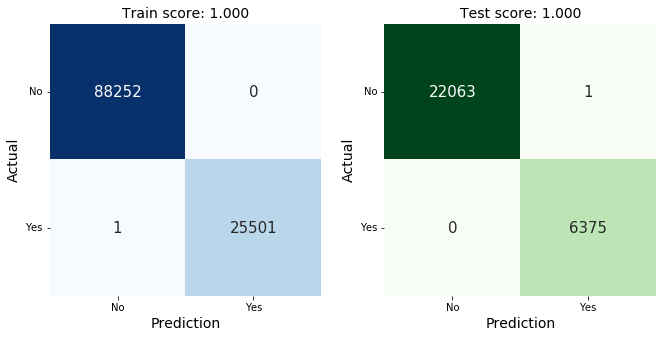

In [22]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

# Feature Importance

,feature,importance,stdev
21,RISK_MM,0.347984,0.000834
2,MaxTemp,0.000067,0.000021
0,Location,0.000025,0.000015
14,Pressure9am,0.000021,0.000009
9,WindDir3pm,0.000009,0.000006
20,RainToday,0.000009,0.000006
12,Humidity9am,0.000009,0.000000
8,WindDir9am,0.000007,0.000007


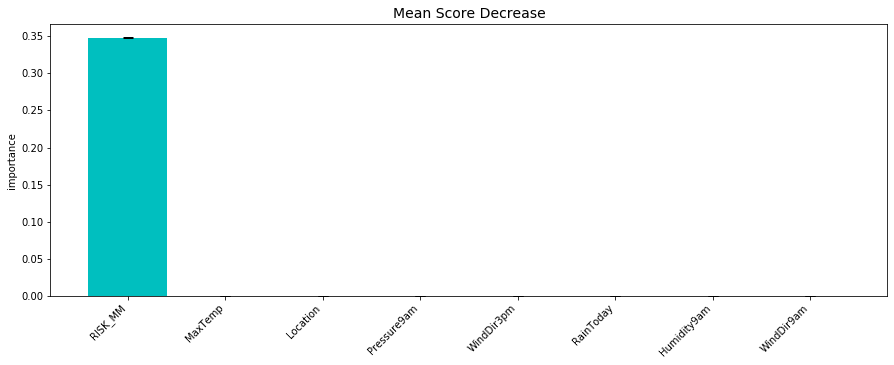

In [23]:
mean_score_decrease(X_train, y_train, model, plot=True, topk=8)

# Tuning - 1

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard',transform='yeo-johnson'), ["RISK_MM"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Location",""])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])